# Task 2: Social Media Data Collection

## Phase 1: Importing Libraries

In [204]:
import json
import os
import re
import sklearn
import random
import cld3
import twint
import nest_asyncio as na
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [205]:
from textblob import TextBlob
from twython import Twython
from wordcloud import WordCloud
from stopwords import STOPWORDS
from nltk import classify, NaiveBayesClassifier
from nltk.corpus import twitter_samples
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## Phase 2: Getting data:

### Tag Chosen: \#ausvsind

For this phase, I have used the library twint to get tweets, and stored it in a file called ```output.json```. Once that is done, we take the relevant features and store them as lists. Later we use a Sentiment Analysis model to generate a sentiment features for each tweet. This was done using the NaiveBayesClassifier of nltk. I trained the model on anotated twitter corpus from nltk (around 10k in total), and then assigned the sentiment to each tweet.

In [206]:
def get_tweets(fileName):
    '''
        Reads the json file given in the argument, and returns it as a list of json objects. 
    '''
    tweets = []
    for line in open(fileName, 'r'):
        tweets.append(json.loads(line))
    return tweets

In [215]:
def get_information(tweets):
    '''
        Gets relevant features from a list of json objects provided (tweets).
        The features extracted are:
            date of tweet,
            time of tweet,
            username of tweeter,
            text of tweet,
            likes of tweet,
            replies of tweet,
            hashtags used in tweet
    '''
    date = []
    time = []
    username = []
    text = []
    likes = []
    replies = []
    hashtags = []
    for tweet in tweets:
        date.append(re.sub('-','',tweet['date']))
        time.append(re.sub(':','',tweet['time'])[0:2])
        username.append(tweet['username'])
        text.append(tweet['tweet'])
        likes.append(tweet['likes_count'])
        replies.append(tweet['replies_count'])
        hashtags.append(tweet['hashtags'])
    
    return date, time, username, text, likes, replies, hashtags

In [216]:
def clean_tweet(tweet):
    '''
        Given a string, cleans and returns a tokenized list.
        Regex is used to remove 
            1. http(s) links
            2. twitter mentions
    '''
    clean = re.sub('http[s]:\/\/\S+','',tweet)
    clean = re.sub('@\S+', '', clean)
    return word_tokenize(clean)

In [217]:
def clean_tweets_list(tweets):
    '''
        Given a list of string, returns a list of cleaned strings.
        This function is used with clean_tweet() function.
    '''
    cleaned_tweets = []
    for tweet in tweets:
        cleaned_tweets.append(clean_tweet(tweet))
    return cleaned_tweets

In [218]:
def prep_model(tweets):
    '''
        Given a list of tweets, it creates a generator for it.
        
        A generator is basically a dictionary, it is required so as to use the NaiveBayesClassifier.
        
        Since NaiveBayes model considers probability of occurance as n-grams, we are considering n=1.
        For Unigrams, we simply tokenize the sentences and use it. For simplicity we have considered
        that each word only occurs once, hence having equal probability in a given sentence.
    '''
    for tweet in tweets:
        yield dict([token, True] for token in tweet)

In [219]:
def get_dataset():
    '''
        Prepares the dataset by getting the pre-annotated twitter samples from nltk. Once that is done,
        we clean it and prepare it such that it is ready to be put into the model.
        Finally, we create a list of tuples, where tuple is of the form of (tweet, sentiment)
        Sentiment:
            1: Positive
            0: Negative
    '''
    pos_tweet = twitter_samples.strings('positive_tweets.json')
    neg_tweet = twitter_samples.strings('negative_tweets.json')
    pos_tweet = clean_tweets_list(pos_tweet)
    neg_tweet = clean_tweets_list(neg_tweet)

    pos_model_tweets = prep_model(pos_tweet)
    neg_model_tweets = prep_model(neg_tweet)
    
    dataset = []
    for tweet in pos_model_tweets:
        dataset.append((tweet, 1))
    for tweet in neg_model_tweets:
        dataset.append((tweet, 0))

    return dataset

In [220]:
def train_model():
    '''
        Trains the dataset using NaiveBayesClassifier, and gives a test accuracy.
        It gets the dataset from the get_dataset() function.
        A 75:25 ration is used for splitting into train:test dataset. 
    '''
    dataset = get_dataset()
    train, test = train_test_split(dataset, test_size=0.25, shuffle=True)
    nbc = NaiveBayesClassifier.train(train)
    
    print("Accuracy is: ", classify.accuracy(nbc, test)*100)
    return nbc

In [221]:
# Gets all the tweets and required information
tweets = get_tweets('output.json')
date, time, username, text, likes, replies, hashtags = get_information(tweets)

In [222]:
# Calls the model
nbc = train_model()

Accuracy is:  97.96000000000001


In [223]:
def predict_sentiment(text, nbc):
    '''
        Given a list of text, it stores the sentiment of each text as a corresponding list. 
        This is done using the NaiveBayesClassifier object passed. 
    '''
    tweet_sentiment = []
    for tweet in text:
        cleaned_tweet = clean_tweet(tweet)
        model_tweet = dict([token, True] for token in cleaned_tweet)
        sentiment = nbc.classify(model_tweet)
        tweet_sentiment.append(sentiment)
    return tweet_sentiment

In [224]:
# Gets sentiment assosciated with each tweet
sentiment = predict_sentiment(text, nbc)

## Phase 3: Data Representation and Inference Drawing

Firstly, we create a dataframe out of all the lists of data we have, so as to make it easy to play with them. This is done using the pandas library. After that we have created 7 graphs detailing difference ideas the data conveys
  * Date VS Tweets VS Sentiment
  * Hour of Day VS Tweets VS Likes
  * Hashtags WordCloud
  * Languages used except English
  * Users with >100 tweets, with sentiment
  * Users with >50 tweets against followers
  * Users with >50 tweets against freinds

In [225]:
def create_dataframe(date, time, username, text, likes, replies, hashtags, sentiment):
    '''
        Prepares a DataFrame from the list provided. The DataFrame is then sorted according to date and time
        to give an accurate representation.
    '''
    df = pd.DataFrame(
    {
        'date': date,
        'time': time,
        'username': username,
        'text': text,
        'likes': likes,
        'replies': replies,
        'hashtags': hashtags,
        'sentiment': sentiment
    })
    df.sort_values(by=['date', 'time'], inplace=True)
    return df

In [226]:
# Creation of the dataframe
df = create_dataframe(date, time, username, text, likes, replies, hashtags, sentiment)
df.head()

,date,time,username,text,likes,replies,hashtags,sentiment
18881,20201204,16,lovecricket05,"All for nothing, Indian fielders trying their ...",0,0,[ausvsind],1
18882,20201204,16,omkarpathare256,#AUSvsIND darcy short is australia ka kedar J...,1,1,[ausvsind],0
18883,20201204,16,vhang_vg,Mayank Agarwal needs to come in for Shikhar. A...,1,1,[ausvsind],0
18884,20201204,16,lachy_steele,Lets do this! #AUSvsIND,1,0,[ausvsind],1
18885,20201204,16,samarthoza711,Was the Jadeja-Chahal decision justified? #IN...,0,0,"[indvsaus, ausvsind, ausvind, australia, icc]",1


In [227]:
# Assigning some custom colors for visual representation
BLUE = '#5CE1FF'
PURPLE = '#957ED8'
YELLOW = '#FFF328'
RED = '#FF2828'
GREEN = '#97C466'

In [228]:
def dateVStweets(df):
    '''
        Creates a bar graph of Date VS Number of tweets. This is then overlapped by Date VS Average Sentiment.
    '''
    num = df.groupby(['date']).count()
    avg = df.groupby(['date']).mean()
    color = [BLUE, PURPLE, BLUE, PURPLE, YELLOW, PURPLE, PURPLE, PURPLE, PURPLE, PURPLE, YELLOW, PURPLE, PURPLE, BLUE]
    plt.bar(df.date.unique(), num.time,color=color)
    blue_patch = mpatches.Patch(color=BLUE, label='India Won')
    yellow_patch = mpatches.Patch(color=YELLOW, label='Australia Won')
    purple_patch = mpatches.Patch(color=PURPLE, label='No Match')
    red_patch = mpatches.Patch(color=RED, label='Average Sentiment')
    plt.tight_layout()
    plt.title("Date VS Tweets VS Sentiment")
    plt.xticks(rotation=90)
    plt.grid(alpha=0.5)
    plt.xlabel("Date")
    plt.ylabel("Number of tweets")
    plt.legend(handles=[blue_patch, yellow_patch, purple_patch, red_patch])
    axes = plt.twinx()
    axes.plot(df.date.unique(), avg.sentiment, color=RED)
    axes.set_ylabel('Average Sentiment per day')
    plt.show()
    return

### Date VS Tweet VS Sentiment

Inferences which can be drawn from the graph:
  * Number of tweets in general is way more on the days when matches were held (Exception: 14/12/2020)
  * Number of tweets are usually higher on days after a match compared to days without match the day before.
  * Average Sentiment often takes a drop on match days, possibly reflecting the ups and downs of the match, and the general perspective of indian viewer (Exception: 14/12/2020)
  * Average Sentiment on the day after the match is usually higher if India wins. This can be attributed to people forgetting the ups and downs of the match, and concentrating on the positive feeling of victory. (Exception: 08/12/2020, which can be attributed to a series win of India over Australia, thus the positive of series victory overshadowing negativity of losing.)
  * During the interim time between T20 and ODI series (09/12/2020 - 13/12/2020) there was observed to be a general drop in average sentiment, which could be attributed to just the love of cricket. The increase on 14/12/2020 could also be attributed to happiness related to the matches being back. 

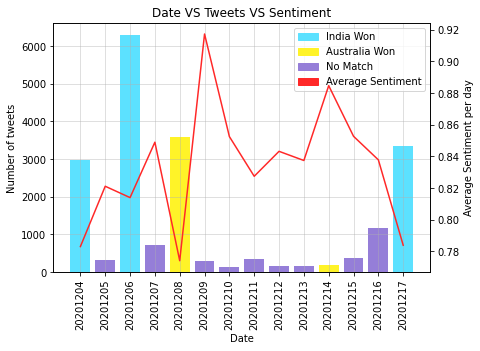

In [230]:
# Creates the graph of Date VS Tweets VS Sentiment
dateVStweets(df)

In [255]:
def timeVStweets(df):
    '''
        Creates a bar graph of Hour in the day VS number of tweets. This is overlapped by average number
        of likes per hour of the day.
    '''
    df = df.sort_values(by=['time'])
    num = df.groupby(['time']).count()
    avg = df.groupby(['time']).mean()
    blue_patch = mpatches.Patch(color=BLUE, label='Number of Tweets')
    red_patch = mpatches.Patch(color=RED, label='Average number of Likes')
    plt.bar(df.time.unique(), num.likes,color=BLUE)
    plt.grid(alpha=0.3)
    plt.title("Time VS Tweets VS Sentiment")
    plt.xlabel('Hour in the day')
    plt.ylabel('Number of tweets')
    plt.legend(handles=[blue_patch,red_patch], loc='upper center', fontsize='small')
    axes = plt.twinx()
    axes.plot(df.time.unique(), avg.likes, color=RED)
    axes.set_ylabel('Average Likes per hour')
    plt.tight_layout()
    plt.show()

### Hour VS Tweet VS Likes

Inferences which can be drawn from the graph:

  * Majority of the tweets were during the time of the match (1330-1730)
  * Average number of likes spiked during non-match hours (1800, 2000, 0400, 0800, 0900).
  * Spike around 1800 and 2000 can be explained by the basic reason that liking takes more time (scrolling and finding agree-able opinions) than commenting. People often scroll through twitter to find like-minded opinions throughout the timeline of the match, and this can only be done after the match due to the time it takes.
  * Spike around 0400, 0800 and 0900 can be seen as 'reflection to the past', as in, they are going through past days tweets and hence increasin in average likes per hour. 
  * Number of tweets from 2300-0800 are seen to be very less, since it is the sleeping time for most indians. 

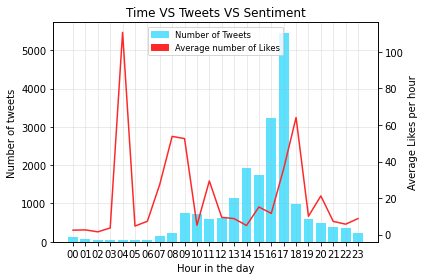

In [256]:
# Creates the graph of Time VS Tweets VS Likes
timeVStweets(df)

In [258]:
def hashtagsWordCloud(df):
    '''
        Creates a wordcloud of hashtags excluding ausvsind (and other hashtags like that).
        The exclusion was done since the tweets were collected on the basis of having those particular tags,
        hence all tweets must have it. 
        
        A list of stopwords is used to prevent meaningless words from spoiling the data
    '''
    hashtags_list = df.hashtags.to_list()
    hashtags = " "
    for tag_list in hashtags_list:
        for tags in tag_list:
            hashtags += tags + " "
    
    STOPWORDS.append('ausvsind')
    STOPWORDS.append('ausvind')
    STOPWORDS.append('indvsaus')
    STOPWORDS.append('indvaus')

    wordcloud = WordCloud(
        width=700, 
        height=500, 
        max_font_size=100,
        max_words=100,
        background_color='white',
        stopwords=STOPWORDS,).generate(hashtags)
    plt.figure()
    plt.title("Most Frequent Hashtags except indvsaus")
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

### Hashtags WordCloud

Inferences which can be drawn from this graph:

 * Since the tweets are from 04/12/2020 - 17/04/2020, time during which the whole T20 series was played, we can see that tags regarding it has dominated.
 * Though there were 2 ODI games played during this time, we can see that clearly ODI has fallen out of favour due to the high popularity of T20s
 * Virat Kohli, Hardik Pandya and Chahal seem to be most popular tags related to players. This can be due to them being some of the fan favorites, and best T20 players in Indian team
 * Youngsters Prtihvi Shaw and Natarajan seemed to be in the mix too due to their performances.
 * Smaller mentions of Rohit Sharma and MS Dhoni can be attributed to fans missing those players. 
 * Smaller mention of terms like 'bordergavaskartrophy' is due to the diminishing importance of older legends, where the newer generations view it as a simple India VS Australia series. 

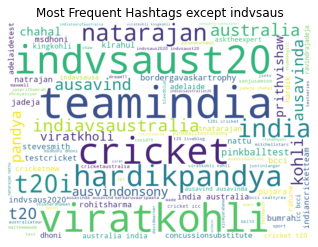

In [276]:
# Creates wordcloud
hashtagsWordCloud(df)

In [270]:
def languageVStweet(df):
    '''
        Uses pyCLD3 to determine languages, and find frequency of tweet in that language. 
        A trust value is computed, and if it is not trustable (mentioned as a parameter in the 4-tuple returned)
        it is ignored. 
        All tweets of 'en' language are ignored as well.
        Mean trust is calculated using the trust value of each language.
        
        A conscience decision was made to use pyCLD3 instead of TextBlob (which uses Google Translate) due to
        complications arrising from time-complexity. 
    '''
    text = df.text.to_list()
    language = {}
    trust = []
    for tweet in text:
        lang = cld3.get_language(tweet)
        if not lang[2] or lang[0] == 'en':
            continue
        else:
            trust.append(lang[1])
        if lang[0] in language:
            language[lang[0]] +=1
        else:
            language[lang[0]] = 1
    mean_trust = 0
    for i in trust:
        mean_trust += i
    mean_trust = mean_trust/len(trust)
    keys = language.keys()
    values = language.values()
    plt.figure(figsize=(15, 10))
    plt.title(f"Languages (Excluding English) VS Number of Tweets   Trust Value: {mean_trust*100}")
    plt.bar(keys, values,color=BLUE)
    plt.xlabel('Languages')
    plt.ylabel('Number of Tweets')
    plt.xticks(rotation=90, fontsize='x-large')
    plt.tight_layout()
    plt.grid(alpha=0.3)
    plt.show()
    return

### Language (Excluding English) VS Number of tweets

Inferences that can be drawn from the graph:
   * Surprisingly, non indian languages have higher number of tweets, which can be either attributed to influence of cricket increasing, or to wrong annotation by pyCLD3
   * People prefer to write in romanized Indian Languages equally compared to Indian Scripts (hi-Latin VS hi). 
   * It is mostly the tweets in Latin script which have resulted in foreign languages (bg, de, lb, fi)
   * Maximum tweets in Indian Language in Indian Scripts are of Hindi and Tamil
 
For more information on language encoding, and the scripts used, visit https://github.com/google/cld3/#supported-languages

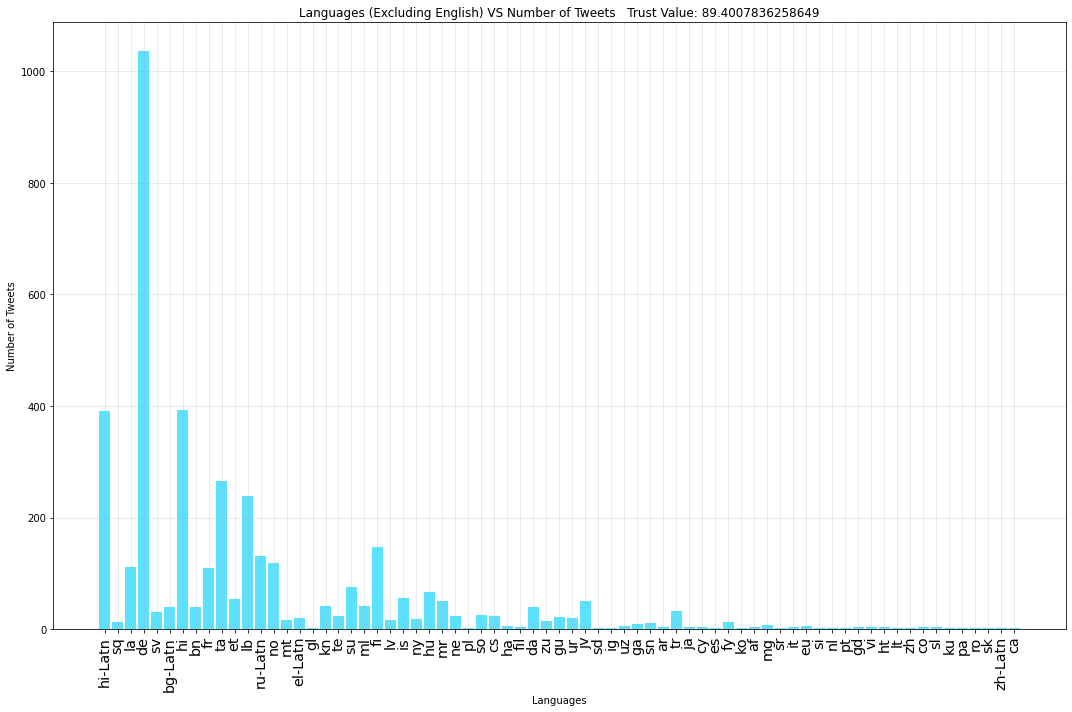

In [277]:
# Creates Language VS Tweet
languageVStweet(df)

In [279]:
def userData(df):
    '''
        Given username, user data is generated and stored in a list of json objects. Only users with >50
        tweets have had their data extracted, to make inferences more meaningful and less noisy. 
        This also had to be done due to Twython using Twitter API, and the limitations associated with it.
        
        Twython was used here due to complications arrising in twint regarding some usernames. 
    '''
    num = df.groupby(['username'], as_index=False).count()
    index_val = num[ num['text'] <= 50 ].index
    num.drop(index_val, inplace=True)
    usernames = num.username.to_list()
    with open("twitter_credentials.json", "r") as file:
        creds = json.load(file)
    twitter = Twython(creds['CONSUMER_KEY'], creds['CONSUMER_SECRET'])
    userdata = []
    for username in usernames:
        userdata.append(twitter.show_user(screen_name=username))
    return userdata

In [272]:
# Gets the user data
userdata = userData(df)

In [273]:
def userVStweets(df, userdata):
    '''
        Gets a bar graph of Users with >100 tweets VS Number of tweets VS Average Sentiment per user.
    '''
    num = df.groupby(['username'], as_index=False).count()
    color = [BLUE, PURPLE, PURPLE, BLUE, BLUE, BLUE, BLUE]
    index_val = num[ num['text'] <= 100 ].index
    num.drop(index_val, inplace=True)
    usernames = num.username.to_list()
 
    tweets = num.text.to_list()
    df = df[df['username'].isin(usernames)]
    df = df.groupby(['username'], as_index=False).mean()
    plt.bar(usernames, tweets, color=color)
    blue_patch = mpatches.Patch(color=BLUE, label='Non Verified')
    purple_patch = mpatches.Patch(color=PURPLE, label='Verified')
    red_patch = mpatches.Patch(color=RED, label='Average Sentiment')
    plt.legend(handles=[blue_patch,purple_patch, red_patch])
    plt.tight_layout()
    plt.grid(alpha=0.3)
    plt.xticks(rotation=45)
    plt.xlabel("Usernames")
    plt.ylabel("Number of Tweets")
    plt.title("Usernames with >100 tweets")
    axes = plt.twinx()
    axes.plot(usernames, df['sentiment'], color=RED)
    axes.set_ylabel('Average Sentiment')
    plt.show()

### User with >100 Tweets VS Number of Tweets VS Average Sentiment

Inferences which can be made from this graph:
   
   * Sentiment values are generally high (>0.65). 
   * Verified accounts generally prefer to go neither to positive, nor too negative. Since they are catering to an Indian base, they try to be positive, but in limits (0.80-0.85)
   * Only 2 private account (controlled by a single user) can be seen, other seem to be more focussed cricket pages. 
   * No correlation can be accurately drawn between Positivity/Negativity of a user and number of tweets.

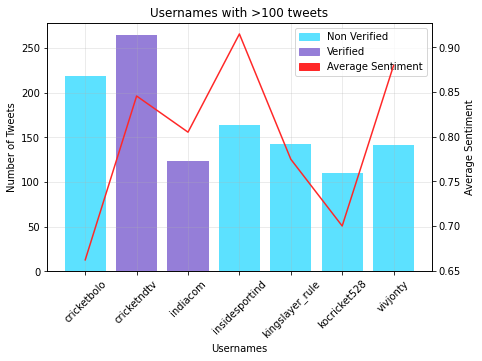

In [278]:
# Creates User VS Tweets VS Sentiment graph
userVStweets(df, userdata)

In [280]:
def userVSfollowers(userdata):
    '''
        Extracts followers, username and verified status from provided userdata.
        We have removed usernames with >50000 followers to make the data a bit less noisy and 
        visually appealing. 
    '''
    followers = []
    screenname = []
    verified = []
    for user in userdata:
        if user['followers_count'] > 50000:
            continue
        followers.append(user['followers_count'])
        screenname.append(user['screen_name'])
        verified.append(user['verified'])
    color = []
    for ver in verified:
        if not ver:
            color.append(BLUE)
        else:
            color.append(PURPLE)
    plt.bar(screenname, followers, color=color)
    blue_patch = mpatches.Patch(color=BLUE, label='Non Verified')
    purple_patch = mpatches.Patch(color=PURPLE, label='Verified')
    plt.legend(handles=[blue_patch,purple_patch])
    plt.title('Number of Followers of most active accounts')
    plt.grid(alpha=0.3)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

### Username VS Number of Followers

Inferences which can be drawn:
   * Verified accounts have significantly greater number of followers than non verified in general. 
   * Around 8 accounts only seem to be of private users, all other seem to be dedicated accounts for either cricketing or news.
   * Of the non verified accounts, Cricketing/News account have more following compared to personal accounts.

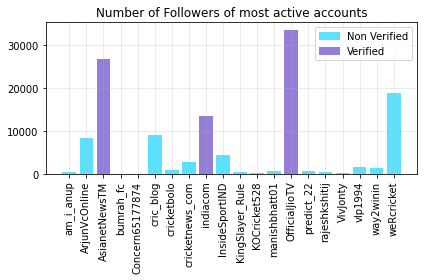

In [275]:
# Creates User VS Number of Followers graph
userVSfollowers(userdata)

In [200]:
def userVSfriends(userdata):
    '''
        Creates a bar graph of Username VS Number of Friends.
        Only usernames with friends <3000 were taken for representation convenience
    '''
    friends = []
    screenname = []
    verified = []
    for user in userdata:
        if user['friends_count'] > 3000:
            continue
        friends.append(user['friends_count'])
        screenname.append(user['screen_name'])
        verified.append(user['verified'])
    color = []
    for ver in verified:
        if not ver:
            color.append(BLUE)
        else:
            color.append(PURPLE)
    plt.bar(screenname, friends, color=color)
    blue_patch = mpatches.Patch(color=BLUE, label='Non Verified')
    purple_patch = mpatches.Patch(color=PURPLE, label='Verified')
    plt.legend(handles=[blue_patch,purple_patch])
    plt.title('Number of Friends of most active accounts')
    plt.grid(alpha=0.3)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

### Username VS Number of Friends

Inferences that can be drawn:
   * Most verified accounts have significantly lower amount of friends compared to followers 
   * Some non-verified cricket pages have higher number of friends compared to both verified pages and personal accounts. 
   * Mostly personal account have less number of friends as well, leading to possible conclusion that they use the account for mostly spamming opinions.

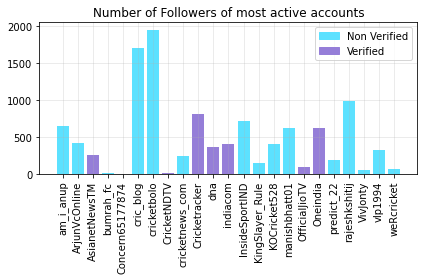

In [281]:
# Gets Username VS Friends graph
userVSfriends(userdata)